In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import time
from datetime import date

### Trading Simulations


* Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [2]:
trade_df = pd.read_parquet('/content/forex_df_models_2025_08_27.parquet.brotli')
trade_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265048 entries, 0 to 9774
Columns: 323 entries, Open to is_correct_pred14
dtypes: datetime64[ns](2), float32(2), float64(120), int32(163), int64(31), object(5)
memory usage: 488.4+ MB


### Calculate financial outcome from simulations for one predictor 'pred10_rf_proba'

In [3]:
PREDICTIONS = [k for k in trade_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_strong_trend',
 'pred1_manual_prev_growth',
 'pred2_manual_bullish',
 'pred3_manual_bearish',
 'pred4_manual_momentum_up',
 'pred5_manual_momentum_down',
 'pred6_manual_trade_balance_us_mom',
 'pred7_dt',
 'pred8_dt_proba',
 'pred9_rf',
 'pred10_rf_proba',
 'pred11_xgb1',
 'pred12_xgb1_proba',
 'pred13_xgb2',
 'pred14_xgb2_proba']

In [4]:
# current prediction
pred = 'pred10_rf_proba'

In [5]:
# Total Number of Investment Opportunities
trade_df[trade_df.split=='test'].Close_x.count()

np.int64(39394)

In [6]:
# Total Number of Trading Hours
trade_df[trade_df.split=='test'].Date.nunique()

78

In [7]:
TO_PREDICT = [g for g in trade_df.columns if (g.find('future')>=0)]
TO_PREDICT

['growth_future_1h', 'is_positive_growth_1h_future']

In [8]:
# SAMPLE: compare the predictions from 'pred12_xgb1_proba' to real is_positive_growth_1h_future
trade_df[['growth_future_1h', 'is_positive_growth_1h_future',pred]].sample(5)

,growth_future_1h,is_positive_growth_1h_future,pred10_rf_proba
3310,1.000068,1,1
8570,1.001204,1,1
6101,0.999707,0,0
6223,1.000881,1,0
9076,0.998764,0,1


In [9]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that currency pair (buy)
trade_df['sim1_gross_rev_pred10'] = trade_df[pred] * 100 * (trade_df['growth_future_1h']-1)

In [10]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
trade_df['sim1_fees_pred10'] = -trade_df[pred] * 100 * 0.002

In [11]:
# NET REVENUE: GROSS_REVENUE + FEES
trade_df['sim1_net_rev_pred10'] = trade_df['sim1_gross_rev_pred10'] + trade_df['sim1_fees_pred10']

In [12]:
# sample results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close_x']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred10','sim1_fees_pred10','sim1_net_rev_pred10']

trade_df[(trade_df.split=='test')&(trade_df[pred]==1)][COLUMNS_FIN_RESULT].sample(5)

,Date,Ticker,Close_x,growth_future_1h,is_positive_growth_1h_future,pred10_rf_proba,sim1_gross_rev_pred10,sim1_fees_pred10,sim1_net_rev_pred10
8638,2025-05-22,RUB=X,79.629997,0.999372,0,1,-0.062785,-0.2,-0.262785
10600,2025-05-13,NZDUSD=X,0.588131,1.001472,1,1,0.147245,-0.2,-0.052755
11440,2025-07-08,THB=X,32.480000,1.000308,1,1,0.030795,-0.2,-0.169205
12268,2025-08-19,NZDUSD=X,0.591996,1.001363,1,1,0.136347,-0.2,-0.063653
11507,2025-07-08,EURCHF=X,0.932970,1.000204,1,1,0.020367,-0.2,-0.179633


In [13]:
# DAILY INVESTMENTS
filter_test_and_positive_pred = (trade_df.split=='test')&(trade_df[pred]==1)
df_investments_count_daily = pd.DataFrame(trade_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

333.0


In [14]:
# how many times do we invest daily (a lot)
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_proba,78.0,309.730769,32.118156,210.0,293.0,308.5,333.0,370.0


In [15]:
trade_df[(trade_df.split=='test')&(trade_df[pred]==1)][['sim1_gross_rev_pred10','sim1_fees_pred10','sim1_net_rev_pred10']].sum()

,0
sim1_gross_rev_pred10,59.667601
sim1_fees_pred10,-4831.800000
sim1_net_rev_pred10,-4768.932399


### Calculate financial results for all fields

In [16]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating simulation for prediction {pred}:')
  print(f"    Count times of investment {len(trade_df[(trade_df.split=='test')&(trade_df[pred]==1)])} out of {len(trade_df[(trade_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  trade_df['sim1_gross_rev_'+pred_prefix] = trade_df[pred] * 100 * (trade_df['growth_future_1h']-1)
  trade_df['sim1_fees_'+pred_prefix] = -trade_df[pred] * 100 * 0.002
  trade_df['sim1_net_rev_'+pred_prefix] = trade_df['sim1_gross_rev_'+pred_prefix] + trade_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (trade_df.split=='test')&(trade_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100)
  sim1_count_investments = len(trade_df[filter_test_and_positive_pred])
  sim1_gross_rev = trade_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = trade_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = trade_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_hourly = pd.DataFrame(trade_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_hour = df_investments_count_hourly[pred].mean()
  sim1_q75_investments_per_hourly = df_investments_count_hourly[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_hourly # 30 (trading) days  in a row with positive predictions
  # CAGR: average growth per year.
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_hour,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {trade_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in ~ 3-Months (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (78 Days) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per hour: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_hourly))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_hour','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating simulation for prediction pred0_manual_strong_trend:
    Count times of investment 25481 out of 39394 TEST records
    Financial Result: 
 sim1_gross_rev_pred0      -5.824224
sim1_fees_pred0        -5096.200000
sim1_net_rev_pred0     -5100.224224
dtype: float64
        Count Investments in ~ 3-Months (on TEST): 25481
        Gross Revenue: $-5
        Fees (0.2% for buy+sell): $5096
        Net Revenue: $-5100
        Fees are -87500 % from Gross Revenue
        Capital Required : $1177500 (Vbegin)
        Final value (Vbegin + Net_revenue) : $1172399 (Vfinal)
        Average CAGR on TEST (78 Days) : 0.999, or -0.1% 
        Average daily stats: 
            Average net revenue per investment: $-0.2 
            Average investments per hour: 333 
            Q75 investments per day: 392 
=============================================+
Calculating simulation for prediction pred1_manual_prev_growth:
    Count times of investment 14199 out of 39394 TEST records
    Financial Re

In [17]:
df_sim1_results['sim1_growth_capital_1h'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [18]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_hour,sim1_capital,sim1_CAGR,sim1_growth_capital_1h
0,pred0_manual_strong_trend,25481,-5.824224,-5096.2,-5100.224224,NaN,-0.200158,326.679487,1177500.0,0.998915,0.995669
1,pred1_manual_prev_growth,14199,-84.896443,-2839.8,-2923.296443,NaN,-0.205880,182.038462,586500.0,0.998752,0.995016
2,pred2_manual_bullish,269,1.708930,-53.8,-52.091070,31.481679,-0.193647,26.900000,72000.0,0.999819,0.999277
3,pred3_manual_bearish,229,-0.048557,-45.8,-45.848557,NaN,-0.200212,25.444444,72000.0,0.999841,0.999363
4,pred4_manual_momentum_up,4846,-21.401401,-969.2,-990.401401,NaN,-0.204375,71.264706,288000.0,0.999139,0.996561
5,pred5_manual_momentum_down,5166,20.269197,-1033.2,-1012.730803,50.973899,-0.196038,75.970588,304500.0,0.999167,0.996674
6,pred6_manual_trade_balance_us_mom,10656,14.856047,-2131.2,-2116.343953,143.456736,-0.198606,507.428571,1530000.0,0.999654,0.998617
7,pred7_dt,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,pred8_dt_proba,39394,11.703484,-7878.8,-7862.496516,673.201228,-0.199586,505.051282,1545000.0,0.998725,0.994911
9,pred9_rf,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_hour',
    y='sim1_CAGR',
    size='sim1_growth_capital_1h',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per hour)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_1h': '~3-Month Capital Growth'},
    height=600  # <- Increase height here

)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

 ### Detailed info from the bubble chart above on the winners

* Top ML (XGBoost and Random Forest) results

In [20]:
df_sim1_results[df_sim1_results.prediction.isin(['pred14_xgb2_proba', 'pred12_xgb1_proba', 'pred10_rf_proba', 'pred8_dt_proba'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_hour,sim1_capital,sim1_CAGR,sim1_growth_capital_1h
8,pred8_dt_proba,39394,11.703484,-7878.8,-7862.496516,673.201228,-0.199586,505.051282,1545000.0,0.998725,0.994911
10,pred10_rf_proba,24159,59.667601,-4831.8,-4768.932399,80.978620,-0.197398,309.730769,999000.0,0.998804,0.995226
12,pred12_xgb1_proba,18,1.150996,-3.6,-2.449004,3.127727,-0.136056,1.500000,6000.0,0.999898,0.999592
14,pred14_xgb2_proba,1,0.510235,-0.2,0.310235,0.391976,0.310235,1.000000,3000.0,1.000026,1.000103


* other top manual results

In [21]:
df_sim1_results[df_sim1_results.prediction.isin(['pred2_manual_bullish', 'pred5_manual_momentum_down', 'pred6_manual_trade_balance_us_mom'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_hour,sim1_capital,sim1_CAGR,sim1_growth_capital_1h
2,pred2_manual_bullish,269,1.708930,-53.8,-52.091070,31.481679,-0.193647,26.900000,72000.0,0.999819,0.999277
5,pred5_manual_momentum_down,5166,20.269197,-1033.2,-1012.730803,50.973899,-0.196038,75.970588,304500.0,0.999167,0.996674
6,pred6_manual_trade_balance_us_mom,10656,14.856047,-2131.2,-2116.343953,143.456736,-0.198606,507.428571,1530000.0,0.999654,0.998617


###  Advanced Simulation

* to_predict = 'is_positive_growth_4h_future'
* invest ~20% of capital each day, REINVEST PREVIOUS GAINS
* use predict_proba predictions
* select top1..3..x predictions > threshold (0.56)
* invest proportionally the prediction
* stop loss y%
* take profit z%
* Not included: portfolio optimization

#### Define rank of prediction

From the fxPAIRS_model.ipynb notebook:
- trade_df['pred13_xgb2'] = y_pred_all
- trade_df['pred14_xgb2_proba'] = (y_pred_all >= 0.58).astype(int)

In [22]:
# rank of prediction

trade_df["pred13_rank"] = trade_df.groupby('Date')['pred13_xgb2'].rank(method='first',ascending=False)

In [23]:
# CHECK RANK FOR 1 DAY:

first_trading_day_2025 = trade_df[trade_df.Date>='2025-01-01'].Date.unique().astype(str)[0]
first_trading_day_2025
print(f'First trading day in 2025: {first_trading_day_2025}, count predictions = {len(trade_df[trade_df.Date==first_trading_day_2025])} different forex currency pairs')

First trading day in 2025: 2025-01-01, count predictions = 226 different forex currency pairs


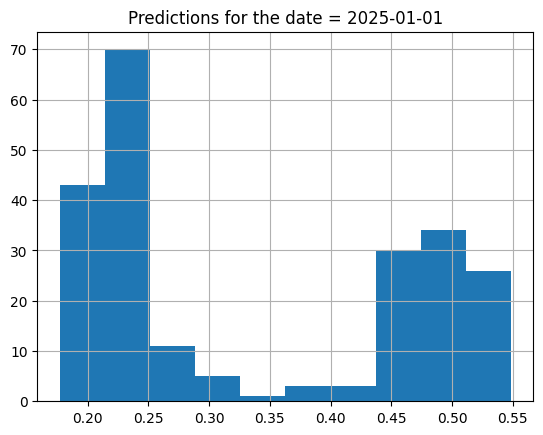

In [ ]:
trade_df[trade_df.Date==first_trading_day_2025].pred13_xgb2.hist()
plt.title(f'Predictions for the date = {first_trading_day_2025}')

# Show the plot
plt.show()

In [24]:
trade_df[trade_df.Date==first_trading_day_2025][['Date','Ticker','pred13_xgb2','pred13_rank']].sort_values(by='pred13_rank').head(5)

,Date,Ticker,pred13_xgb2,pred13_rank
8318,2025-01-01,EURHUF=X,0.548428,1.0
8323,2025-01-01,EURHUF=X,0.547214,2.0
8275,2025-01-01,JPY=X,0.546035,3.0
8324,2025-01-01,EURHUF=X,0.545483,4.0
8322,2025-01-01,GBPJPY=X,0.543757,5.0


#### Define Min(Low) for the next 1 hour and Max(High) for the next 1 hour

In [25]:
# Sort the DataFrame by Ticker and Date
trade_df = trade_df.sort_values(by=['Ticker', 'Date'])

trade_df['growth_future_1h'].describe().T

,growth_future_1h
count,265025.000000
mean,1.000001
std,0.001278
min,0.953440
25%,0.999643
50%,1.000000
75%,1.000361
max,1.048833


In [26]:
# take profit if growth >=20  (95th percentile)
trade_df['growth_future_1h'].quantile(0.95)

np.float64(1.0015661360272035)

In [27]:
# stop loss when -11%
trade_df['growth_future_1h'].quantile(0.1)

np.float64(0.99900198688399)

In [28]:
# check a sample on the test dataset
trade_df[trade_df.split=='test'][['Date','High','Low','Close_x','Ticker','growth_future_1h']].sample(10)

,Date,High,Low,Close_x,Ticker,growth_future_1h
8938,2025-06-18,78.375000,78.335999,78.375000,RUB=X,1.001595
12321,2025-08-26,1.348981,1.344899,1.348109,GBPUSD=X,0.999434
11351,2025-06-30,0.936800,0.935630,0.936060,EURCHF=X,1.000107
10609,2025-05-15,0.840700,0.840350,0.840490,EURGBP=X,0.999988
7158,2025-06-18,4.246000,4.246000,4.246000,MYR=X,0.999882
12254,2025-08-26,147.608002,147.248001,147.516006,JPY=X,1.001864
6755,2025-05-13,4.335000,4.330000,4.330000,MYR=X,0.999769
11278,2025-06-25,11.062920,11.054140,11.056500,EURSEK=X,1.000136
11999,2025-08-06,1.594240,1.592810,1.593290,EURCAD=X,1.000019
11688,2025-07-18,172.858994,172.703995,172.826004,EURJPY=X,1.000139


In [29]:
# Define a function to get the rolling max High and min Low for the next 30 trading hours

# Sort the DataFrame: Sorting by Ticker and Date ensures that we are looking at each ticker's data in chronological order.
# Rolling window calculation: We use the rolling method with a window of 30 to calculate the maximum high and minimum low over the next 30 hours.
# The shift method is used to align these values correctly with the current row.

def rolling_max_min(df, window=30):
    # high/low in 30 hours
    df['Max_High_Next_30'] = df['High'].rolling(window=window, min_periods=1).max().shift(-window+1)
    df['Min_Low_Next_30'] = df['Low'].rolling(window=window, min_periods=1).min().shift(-window+1)

    # low in 1 day (for lower entry)
    df['Min_Low_Next_1'] = df['Low'].rolling(window=1, min_periods=1).min().shift(-1)
    return df

In [30]:
# Apply the function to each group of Ticker
# Important!: need to drop index from groupby operation (reset_index) - so that you can merge that afterwards
result = trade_df[trade_df.split=='test'][['Date','High','Low','Close_x','Ticker']].groupby('Ticker').apply(rolling_max_min).reset_index(drop=True)
result.head(30)

/tmp/ipython-input-1211545304.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
0,2025-05-12,0.643149,0.641972,0.642319,AUDUSD=X,0.645703,0.635898,0.641396
1,2025-05-12,0.642777,0.641396,0.642488,AUDUSD=X,0.645703,0.635898,0.642257
2,2025-05-12,0.643588,0.642257,0.642529,AUDUSD=X,0.645703,0.635898,0.641787
3,2025-05-12,0.642959,0.641787,0.642537,AUDUSD=X,0.645703,0.635898,0.642508
4,2025-05-12,0.643376,0.642508,0.643306,AUDUSD=X,0.645703,0.635898,0.642880
5,2025-05-12,0.643691,0.642880,0.643269,AUDUSD=X,0.645703,0.635898,0.642996
6,2025-05-12,0.644089,0.642996,0.643849,AUDUSD=X,0.645703,0.635898,0.643178
7,2025-05-12,0.644409,0.643178,0.643178,AUDUSD=X,0.645703,0.635898,0.639591
8,2025-05-12,0.645703,0.639591,0.640767,AUDUSD=X,0.645703,0.635898,0.639918
9,2025-05-12,0.641807,0.639918,0.641449,AUDUSD=X,0.643583,0.635898,0.640533


In [31]:
result[result.Ticker=='AUDUSD=X'].tail(5)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
1844,2025-08-27,0.647249,0.646705,0.646872,AUDUSD=X,NaN,NaN,0.646496
1845,2025-08-27,0.647082,0.646496,0.646914,AUDUSD=X,NaN,NaN,0.646872
1846,2025-08-27,0.647626,0.646872,0.647375,AUDUSD=X,NaN,NaN,0.647207
1847,2025-08-27,0.648046,0.647207,0.647920,AUDUSD=X,NaN,NaN,0.647543
1848,2025-08-27,0.647962,0.647543,0.647962,AUDUSD=X,NaN,NaN,NaN


In [32]:
# Calculate the ratios + safe divide
result['Ratio_MaxHighNext30_to_Close'] = np.where(result['Close_x'] == 0, np.nan, result['Max_High_Next_30']/result['Close_x'])
result['Ratio_MinLowNext30_to_Close'] =  np.where(result['Close_x'] == 0, np.nan,  result['Min_Low_Next_30']/result['Close_x'])

result['Ratio_MinLowNext1_to_Close'] =  np.where(result['Close_x'] == 0, np.nan,  result['Min_Low_Next_1']/result['Close_x'])

In [33]:
result[result.Ticker=='AUDUSD=X'].head(5)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
0,2025-05-12,0.643149,0.641972,0.642319,AUDUSD=X,0.645703,0.635898,0.641396,1.005269,0.990004,0.998563
1,2025-05-12,0.642777,0.641396,0.642488,AUDUSD=X,0.645703,0.635898,0.642257,1.005004,0.989743,0.999640
2,2025-05-12,0.643588,0.642257,0.642529,AUDUSD=X,0.645703,0.635898,0.641787,1.004940,0.989679,0.998845
3,2025-05-12,0.642959,0.641787,0.642537,AUDUSD=X,0.645703,0.635898,0.642508,1.004927,0.989667,0.999955
4,2025-05-12,0.643376,0.642508,0.643306,AUDUSD=X,0.645703,0.635898,0.642880,1.003726,0.988484,0.999338


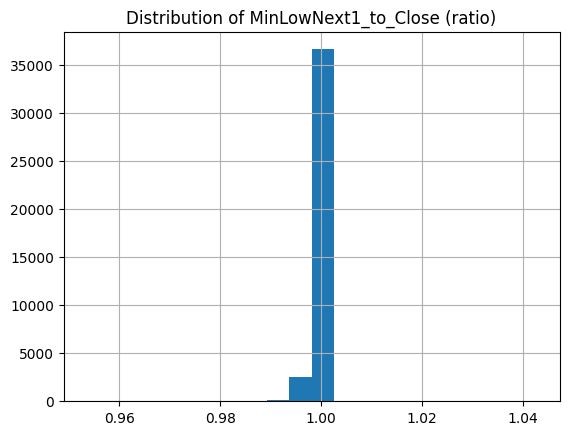

In [34]:
result.Ratio_MinLowNext1_to_Close.hist(bins=20)
plt.title(f'Distribution of MinLowNext1_to_Close (ratio)')

# Show the plot
plt.show()

In [35]:
result.Ratio_MinLowNext1_to_Close.describe().T

,Ratio_MinLowNext1_to_Close
count,39371.000000
mean,0.999318
std,0.001000
min,0.953440
25%,0.999053
50%,0.999523
75%,0.999864
max,1.042759


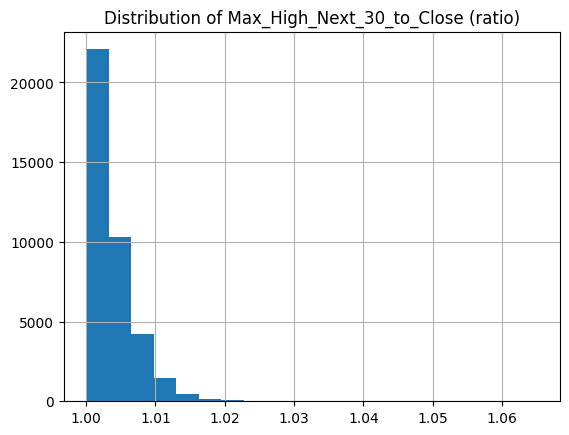

In [36]:
result.Ratio_MaxHighNext30_to_Close.hist(bins=20)
plt.title(f'Distribution of Max_High_Next_30_to_Close (ratio)')

# Show the plot
plt.show()

In [37]:
result.Ratio_MaxHighNext30_to_Close.describe().T

,Ratio_MaxHighNext30_to_Close
count,38727.000000
mean,1.003636
std,0.003376
min,1.000000
25%,1.001223
50%,1.002710
75%,1.005074
max,1.065066


In [38]:
result[result.Ratio_MaxHighNext30_to_Close >= 1.02].sample(5)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
33288,2025-07-10,73.925003,73.925003,73.925003,RUB=X,78.735001,73.925003,77.085999,1.065066,1.000000,1.042759
29862,2025-06-23,0.592874,0.591506,0.591506,NZDUSD=X,0.604047,0.588478,0.589067,1.021202,0.994880,0.995877
38932,2025-07-31,17.979650,17.943800,17.958941,ZAR=X,18.358910,17.943800,17.946301,1.022271,0.999157,0.999296
33483,2025-07-28,80.276100,79.574997,79.889999,RUB=X,82.585999,79.574997,79.775002,1.033746,0.996057,0.998561
32932,2025-06-11,78.410004,78.410004,78.410004,RUB=X,80.500000,78.089996,78.089996,1.026655,0.995919,0.995919


In [39]:
# TAKE PROFIT (2%)
len(result[result.Ratio_MaxHighNext30_to_Close>=1.02])/len(result)

0.00246230390414784

<Axes: >

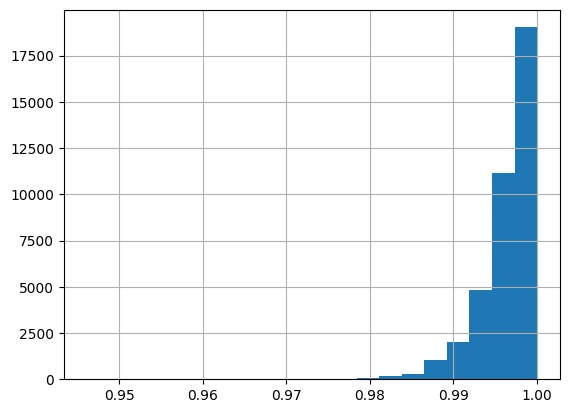

In [40]:
# High intra-day volatility
result.Ratio_MinLowNext30_to_Close.hist(bins=20)

In [41]:
result.Ratio_MinLowNext30_to_Close.describe().T

,Ratio_MinLowNext30_to_Close
count,38727.000000
mean,0.996295
std,0.003693
min,0.946058
25%,0.994974
50%,0.997244
75%,0.998744
max,1.000000


In [42]:
result[result.Ratio_MinLowNext30_to_Close<=1].sample(5)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
184,2025-05-21,0.647119,0.646408,0.646626,AUDUSD=X,0.647119,0.640976,0.644579,1.000764,0.991264,0.996835
39232,2025-08-18,17.642300,17.605000,17.619400,ZAR=X,17.719900,17.565001,17.614700,1.005704,0.996913,0.999733
34446,2025-06-13,1.283300,1.282000,1.282050,SGD=X,1.284800,1.279350,1.281720,1.002145,0.997894,0.999743
11689,2025-07-14,172.468994,172.270996,172.371002,EURJPY=X,173.078995,172.192001,172.222000,1.004107,0.998962,0.999136
5300,2025-05-26,0.936490,0.935430,0.935880,EURCHF=X,0.938660,0.932930,0.934310,1.002970,0.996848,0.998322


In [43]:
# 1% STOP LOSS
len(result[result.Ratio_MinLowNext30_to_Close<=1])/len(result)

0.9830684875869422

In [44]:
# Merge the results back with the original dataframe
trade_df = trade_df.merge(result[['Date', 'Ticker', 'Max_High_Next_30', 'Min_Low_Next_30','Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']], on=['Date', 'Ticker'])

trade_df.sample(5)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,sim1_net_rev_pred13,sim1_gross_rev_pred14,sim1_fees_pred14,sim1_net_rev_pred14,pred13_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
93151,1.598720,1.602240,1.598150,1.601130,0.0,0.0,0.0,EURCAD=X,2025,July,...,-0.087715,0.0,0.0,0.0,289.0,1.602520,1.595860,1.002164,0.997999,0.999831
811561,32.720001,32.748001,32.680000,32.700001,0.0,0.0,0.0,THB=X,2025,June,...,-0.112096,-0.0,0.0,0.0,247.0,32.669998,32.500000,1.002147,0.996933,0.999387
324092,11.150700,11.154700,11.144050,11.149350,0.0,0.0,0.0,EURSEK=X,2025,August,...,-0.118134,-0.0,0.0,0.0,15.0,11.183500,11.134950,1.001968,0.997619,0.999738
830115,32.310001,32.369999,32.290001,32.330002,0.0,0.0,0.0,THB=X,2025,July,...,-0.098949,-0.0,0.0,0.0,452.0,32.480000,32.299999,1.003088,0.997529,0.998765
633192,18.733400,18.736740,18.712999,18.714001,0.0,0.0,0.0,MXN=X,2025,August,...,-0.080962,0.0,0.0,0.0,28.0,18.868999,18.731649,1.002907,0.995607,0.999692


### Generate financial result for one date

In [45]:
from dataclasses import dataclass
#from typing import Optional, Union, Tuple

@dataclass
class SimulationParams:
    initial_capital: float
    threshold: float
    fees: float
    top_k: int
    portfolio_optimization: bool
    stop_loss: float
    take_profit: float
    lower_entry: float

In [46]:
# Example of initializing with some values
sim_params = SimulationParams(
    initial_capital=100,          # initial capital = $100
    threshold=0.58,               # select all binary predictions with probability
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=1,                # automatic sell (with loss) if price (any of next 30 trading hours) is lower than -1% from Close
    take_profit=1.02,              # automatic sell (with profit) if price (any of next 30 days) is higher than +2% from Close
    lower_entry= 0.995                # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

print(sim_params)

SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)


In [47]:
# sorted array of dates for Simulation
DATES = trade_df[trade_df.split=='test'].sort_values(by='Date').Date.unique()
print(f' Min date {DATES.min()}, max date {DATES.max()}')

 Min date 2025-05-12 00:00:00, max date 2025-08-27 00:00:00


In [48]:
date = DATES[0]
date

Timestamp('2025-05-12 00:00:00')

In [49]:
# 1. get TOP_K predictions lower or equals THE THRESHOLD with pred14_xgb2_proba with predictions
if sim_params.top_k is None:
  one_day_predictions_df = trade_df[(trade_df.Date==date)&(trade_df.pred14_xgb2_proba <= sim_params.threshold)]
else:
  one_day_predictions_df = trade_df[(trade_df.Date==date)&(trade_df.pred14_xgb2_proba <= sim_params.threshold)&(trade_df.pred13_rank<=sim_params.top_k)]

In [50]:
one_day_predictions_df[['Date','Ticker'] + TO_PREDICT + ['pred14_xgb2_proba','pred13_rank']].sample(10)

,Date,Ticker,growth_future_1h,is_positive_growth_1h_future,pred14_xgb2_proba,pred13_rank
523225,2025-05-12,INR=X,1.000579,1,0,1.0
287680,2025-05-12,EURSEK=X,0.999363,0,0,9.0
463466,2025-05-12,HKD=X,0.999992,0,0,7.0
68061,2025-05-12,EURCAD=X,1.002044,1,0,10.0
463445,2025-05-12,HKD=X,0.999931,0,0,6.0
68053,2025-05-12,EURCAD=X,1.002044,1,0,10.0
287678,2025-05-12,EURSEK=X,0.999363,0,0,9.0
463478,2025-05-12,HKD=X,0.999992,0,0,7.0
523223,2025-05-12,INR=X,1.000579,1,0,1.0
287688,2025-05-12,EURSEK=X,1.002078,1,0,8.0


In [51]:
# 2. Get non-normalized weights: probability-threshold + 0.01
one_day_predictions_df['weight'] = one_day_predictions_df.pred14_xgb2_proba - sim_params.threshold +0.01

one_day_predictions_df[['Date','Ticker','Close_x'] + TO_PREDICT + ['pred14_xgb2_proba','pred13_rank','weight']].sample(10)

/tmp/ipython-input-2845629530.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Ticker,Close_x,growth_future_1h,is_positive_growth_1h_future,pred14_xgb2_proba,pred13_rank,weight
463488,2025-05-12,HKD=X,7.791060,0.999992,0,0,7.0,-0.57
463005,2025-05-12,HKD=X,7.777300,1.000183,1,0,3.0,-0.57
462986,2025-05-12,HKD=X,7.777300,1.000183,1,0,3.0,-0.57
287699,2025-05-12,EURSEK=X,10.872400,1.002078,1,0,8.0,-0.57
523223,2025-05-12,INR=X,84.581001,1.000579,1,0,1.0,-0.57
463452,2025-05-12,HKD=X,7.791600,0.999931,0,0,6.0,-0.57
287697,2025-05-12,EURSEK=X,10.872400,1.002078,1,0,8.0,-0.57
287662,2025-05-12,EURSEK=X,10.879330,0.999363,0,0,9.0,-0.57
523226,2025-05-12,INR=X,84.581001,1.000579,1,0,1.0,-0.57
463042,2025-05-12,HKD=X,7.776990,1.000836,1,0,2.0,-0.57


In [52]:
# 3. Get normalized weights
one_day_predictions_df['weight_norm'] = one_day_predictions_df['weight']/one_day_predictions_df['weight'].sum()

one_day_predictions_df[['Date','Ticker','Close_x'] + TO_PREDICT + ['pred14_xgb2_proba','pred13_rank','weight', 'weight_norm']].sample(10)

/tmp/ipython-input-2008343675.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Ticker,Close_x,growth_future_1h,is_positive_growth_1h_future,pred14_xgb2_proba,pred13_rank,weight,weight_norm
463043,2025-05-12,HKD=X,7.776990,1.000836,1,0,2.0,-0.57,0.004367
463443,2025-05-12,HKD=X,7.791600,0.999931,0,0,6.0,-0.57,0.004367
287704,2025-05-12,EURSEK=X,10.872400,1.002078,1,0,8.0,-0.57,0.004367
68058,2025-05-12,EURCAD=X,1.551250,1.002044,1,0,10.0,-0.57,0.004367
463472,2025-05-12,HKD=X,7.791060,0.999992,0,0,7.0,-0.57,0.004367
463487,2025-05-12,HKD=X,7.791060,0.999992,0,0,7.0,-0.57,0.004367
68067,2025-05-12,EURCAD=X,1.551250,1.002044,1,0,10.0,-0.57,0.004367
463463,2025-05-12,HKD=X,7.791600,0.999931,0,0,6.0,-0.57,0.004367
199643,2025-05-12,EURHUF=X,403.436005,1.000431,1,0,5.0,-0.57,0.004367
463000,2025-05-12,HKD=X,7.777300,1.000183,1,0,3.0,-0.57,0.004367


In [53]:
# 4. Capital: either 1/30 of initial (assuming you trade every day), or everything that you can sell from 30 hours ago
one_day_predictions_df['investment'] = one_day_predictions_df['weight_norm'] * sim_params.initial_capital /30

one_day_predictions_df[['Date','Ticker','Close_x'] + TO_PREDICT + ['pred14_xgb2_proba','pred13_rank','weight', 'weight_norm','investment']].sample(10)

/tmp/ipython-input-3014627271.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Ticker,Close_x,growth_future_1h,is_positive_growth_1h_future,pred14_xgb2_proba,pred13_rank,weight,weight_norm,investment
463002,2025-05-12,HKD=X,7.777300,1.000183,1,0,3.0,-0.57,0.004367,0.014556
463005,2025-05-12,HKD=X,7.777300,1.000183,1,0,3.0,-0.57,0.004367,0.014556
463460,2025-05-12,HKD=X,7.791600,0.999931,0,0,6.0,-0.57,0.004367,0.014556
287662,2025-05-12,EURSEK=X,10.879330,0.999363,0,0,9.0,-0.57,0.004367,0.014556
199591,2025-05-12,EURHUF=X,403.384003,1.000880,1,0,4.0,-0.57,0.004367,0.014556
287706,2025-05-12,EURSEK=X,10.872400,1.002078,1,0,8.0,-0.57,0.004367,0.014556
463441,2025-05-12,HKD=X,7.791600,0.999931,0,0,6.0,-0.57,0.004367,0.014556
68052,2025-05-12,EURCAD=X,1.551250,1.002044,1,0,10.0,-0.57,0.004367,0.014556
287666,2025-05-12,EURSEK=X,10.879330,0.999363,0,0,9.0,-0.57,0.004367,0.014556
523232,2025-05-12,INR=X,84.581001,1.000579,1,0,1.0,-0.57,0.004367,0.014556


In [54]:
# 5. Lower Entry: the trade is executed only is Low price for next day is lower than bet
one_day_predictions_df['lower_entry'] = (one_day_predictions_df['Ratio_MinLowNext1_to_Close']<=sim_params.lower_entry).astype(int)

# 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold
one_day_predictions_df['stop_loss'] = (one_day_predictions_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

# 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
one_day_predictions_df['take_profit'] = (one_day_predictions_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

one_day_predictions_df.sample(10)

/tmp/ipython-input-2426862937.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2426862937.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2426862937.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit
463487,7.791250,7.791800,7.791040,7.791060,0.0,0.0,0.0,HKD=X,2025,May,...,7.786460,1.002144,0.999417,0.999956,-0.57,0.004367,0.014556,0,1,0
287702,10.878010,10.883700,10.862020,10.872400,0.0,0.0,0.0,EURSEK=X,2025,May,...,10.804810,1.002196,0.992934,0.999797,-0.57,0.004367,0.014556,0,1,0
463483,7.791250,7.791800,7.791040,7.791060,0.0,0.0,0.0,HKD=X,2025,May,...,7.786460,1.000642,0.999263,0.999877,-0.57,0.004367,0.014556,0,1,0
463444,7.792200,7.792400,7.791240,7.791600,0.0,0.0,0.0,HKD=X,2025,May,...,7.776860,1.001754,0.999148,0.999947,-0.57,0.004367,0.014556,0,1,0
287686,10.878010,10.883700,10.862020,10.872400,0.0,0.0,0.0,EURSEK=X,2025,May,...,10.862020,1.002569,0.995596,0.999575,-0.57,0.004367,0.014556,0,1,0
287683,10.895730,10.897000,10.872330,10.879330,0.0,0.0,0.0,EURSEK=X,2025,May,...,10.804810,1.001626,0.992369,0.999942,-0.57,0.004367,0.014556,0,1,0
199591,403.609985,403.700012,403.259003,403.384003,0.0,0.0,0.0,EURHUF=X,2025,May,...,402.959991,1.006454,0.998291,0.999031,-0.57,0.004367,0.014556,0,1,0
463460,7.792200,7.792400,7.791240,7.791600,0.0,0.0,0.0,HKD=X,2025,May,...,7.786460,1.000719,0.999340,0.999928,-0.57,0.004367,0.014556,0,1,0
523223,84.669998,84.669998,84.567001,84.581001,0.0,0.0,0.0,INR=X,2025,May,...,84.567001,1.010511,0.999834,0.999917,-0.57,0.004367,0.014556,0,1,0
287665,10.895730,10.897000,10.872330,10.879330,0.0,0.0,0.0,EURSEK=X,2025,May,...,10.819590,1.002557,0.991695,0.999514,-0.57,0.004367,0.014556,0,1,0


In [55]:
# future_gross_return, depending on lower_entry, take_profit, stop_loss

import random

def get_future_gross_return(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade, investment is untouched, no fees
    return row['investment']

  # buy trade is filled for ALL next cases:
  if row['take_profit']==1 and row['stop_loss']==1:
    if random.random()>0.5: #assume take_profit event was first
      return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))
    else: #assume stop_loss event was first
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  if row['take_profit']==1: # take some good profit, pay fees
    return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))

  if row['stop_loss']==1: # fix the loss, pay fees
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  # no stop_loss and no take_profit
  if pd.isna(row['growth_future_1h']):
    return row['investment'] # no information on growth in 30 hours --> return the same investment in 5 hours
  else:
    return row['investment']*(row['growth_future_1h']+(1-sim_params.lower_entry))

In [56]:
# fees, depending on lower_entry, take_profit, stop_loss

def get_fees(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade ==> no fees
    return 0

  # pay fees in all other cases
  return -row['investment']*sim_params.fees

In [57]:
# 8. calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
one_day_predictions_df['future_gross_return'] = one_day_predictions_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
one_day_predictions_df['fees'] =  one_day_predictions_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
one_day_predictions_df['future_net_return'] = one_day_predictions_df['future_gross_return'] + one_day_predictions_df['fees']

/tmp/ipython-input-4143984713.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-4143984713.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-4143984713.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
# result
one_day_predictions_df

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
68050,1.562530,1.562590,1.550560,1.551250,0.0,0.0,0.0,EURCAD=X,2025,May,...,0.999840,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
68051,1.562530,1.562590,1.550560,1.551250,0.0,0.0,0.0,EURCAD=X,2025,May,...,0.998442,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
68052,1.562530,1.562590,1.550560,1.551250,0.0,0.0,0.0,EURCAD=X,2025,May,...,0.999866,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
68053,1.562530,1.562590,1.550560,1.551250,0.0,0.0,0.0,EURCAD=X,2025,May,...,0.998849,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
68054,1.562530,1.562590,1.550560,1.551250,0.0,0.0,0.0,EURCAD=X,2025,May,...,0.999412,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523231,84.669998,84.669998,84.567001,84.581001,0.0,0.0,0.0,INR=X,2025,May,...,0.999611,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
523232,84.669998,84.669998,84.567001,84.581001,0.0,0.0,0.0,INR=X,2025,May,...,0.999423,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
523233,84.669998,84.669998,84.567001,84.581001,0.0,0.0,0.0,INR=X,2025,May,...,0.999835,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556
523234,84.669998,84.669998,84.567001,84.581001,0.0,0.0,0.0,INR=X,2025,May,...,1.000000,-0.57,0.004367,0.014556,0,1,0,0.014556,0.0,0.014556


### Wrap up one day simulation into a function

In [59]:
sim_params = SimulationParams(
    initial_capital=100,          # initial capital = $100
    threshold=0.58,               # select all binary predictions with probability
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=1,                # automatic sell (with loss) if price (any of next 30 trading hours) is lower than -1% from Close
    take_profit=1.02,              # automatic sell (with profit) if price (any of next 30 days) is higher than +2% from Close
    lower_entry= 0.995                # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

print(sim_params)

SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)


In [60]:
def one_date_simulation(date:str, invest_sum:float, df:pd.DataFrame, sim_params:SimulationParams, predictor:str='pred14_xgb2_proba', rank:str='pred13_rank'):

  rank_column = rank.split('_')[0]+'_rank'
  # 1. get TOP_K (or ALL) predictions from the predictor (pred14_xgb2_proba by default), that are higher than THE THRESHOLD
  if sim_params.top_k is None:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] <= sim_params.threshold)]
  else:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] <= sim_params.threshold)&(df[rank_column]<=sim_params.top_k)]

  FIELDS = ['Close_x', 'Ticker', 'Date', predictor, rank_column, 'growth_future_1h', 'Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']
  result_df = one_day_predictions_df[FIELDS].copy()

  # 2. Get non-normalized weights: probability-threshold + 0.01
  result_df['weight'] = result_df[predictor] - sim_params.threshold +0.01

  # 3. Get normalized weights
  result_df['weight_norm'] = result_df['weight']/result_df['weight'].sum()

  # 4. Make bets to allocate 'invest_sum' across all suitable predictions
  result_df['investment'] = result_df['weight_norm'] * invest_sum

  # 5. Lower Entry: the trade is executed only is Low price for next day is lower than the bet (Adj_Close_today * sim_params.lower_entry)
    # [ONLY TRADES with lower_entry==1 are filled by the exchange]
  result_df['lower_entry'] = (result_df['Ratio_MinLowNext1_to_Close'] <= sim_params.lower_entry).astype(int)

  # 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
  result_df['stop_loss'] = (result_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

  # 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
  result_df['take_profit'] = (result_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

  # 8. Calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
  result_df['future_gross_return'] = result_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
  result_df['fees'] =  result_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
  result_df['future_net_return'] = result_df['future_gross_return'] + result_df['fees']

  return result_df

In [61]:
rank = 'pred13_rank'
rank = rank.split('_')[0]+'_rank'
print(rank)

pred13_rank


In [62]:
# sorted array of dates for Simulation
DATES = trade_df[trade_df.split=='test'].sort_values(by='Date').Date.unique()
print(f'Min date {DATES.min()}, max date {DATES.max()}')
print('--------------')
print(f'The highest number of trading days forex is {len(DATES)}')

Min date 2025-05-12 00:00:00, max date 2025-08-27 00:00:00
--------------
The highest number of trading days forex is 78


In [63]:
date = DATES[60]                   # the index number can be changed.
date

Timestamp('2025-08-04 00:00:00')

In [64]:
r = one_date_simulation(date=date, invest_sum=sim_params.initial_capital/30, df=trade_df, sim_params=sim_params, predictor='pred14_xgb2_proba', rank='pred13_rank')

In [65]:
r

,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
233587,397.059998,EURHUF=X,2025-08-04,0,7.0,1.002327,1.003027,0.997139,0.997139,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
233588,397.059998,EURHUF=X,2025-08-04,0,7.0,1.002327,1.005629,0.999725,1.001964,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
233589,397.059998,EURHUF=X,2025-08-04,0,7.0,1.002327,1.003297,0.999186,0.999688,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
233590,397.059998,EURHUF=X,2025-08-04,0,7.0,1.002327,1.003239,0.999093,0.999570,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
233591,397.059998,EURHUF=X,2025-08-04,0,7.0,1.002327,1.003952,0.999023,0.999915,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833836,32.319000,THB=X,2025-08-04,0,8.0,0.999629,1.003711,0.996908,0.999382,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
833837,32.319000,THB=X,2025-08-04,0,8.0,0.999629,1.003400,0.996600,0.999691,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
833838,32.319000,THB=X,2025-08-04,0,8.0,0.999629,1.003711,0.996908,0.999351,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443
833839,32.319000,THB=X,2025-08-04,0,8.0,0.999629,1.004363,0.997556,0.999103,-0.57,0.004329,0.01443,0,1,0,0.01443,0,0.01443


In [66]:
# initial investment
r.investment.sum()

np.float64(3.3333333333333335)

In [67]:
# result in 30 hours (returns+fees)
r.future_net_return.sum()

np.float64(3.3333333333333335)

### Generate financial result for ALL days

In [68]:
all_dates = trade_df[trade_df.split=='test'].sort_values(by='Date').Date.unique()
all_dates

<DatetimeArray>
['2025-05-12 00:00:00', '2025-05-13 00:00:00', '2025-05-14 00:00:00',
 '2025-05-15 00:00:00', '2025-05-16 00:00:00', '2025-05-19 00:00:00',
 '2025-05-20 00:00:00', '2025-05-21 00:00:00', '2025-05-22 00:00:00',
 '2025-05-23 00:00:00', '2025-05-26 00:00:00', '2025-05-27 00:00:00',
 '2025-05-28 00:00:00', '2025-05-29 00:00:00', '2025-05-30 00:00:00',
 '2025-06-02 00:00:00', '2025-06-03 00:00:00', '2025-06-04 00:00:00',
 '2025-06-05 00:00:00', '2025-06-06 00:00:00', '2025-06-09 00:00:00',
 '2025-06-10 00:00:00', '2025-06-11 00:00:00', '2025-06-12 00:00:00',
 '2025-06-13 00:00:00', '2025-06-16 00:00:00', '2025-06-17 00:00:00',
 '2025-06-18 00:00:00', '2025-06-19 00:00:00', '2025-06-20 00:00:00',
 '2025-06-23 00:00:00', '2025-06-24 00:00:00', '2025-06-25 00:00:00',
 '2025-06-26 00:00:00', '2025-06-27 00:00:00', '2025-06-30 00:00:00',
 '2025-07-01 00:00:00', '2025-07-02 00:00:00', '2025-07-03 00:00:00',
 '2025-07-04 00:00:00', '2025-07-07 00:00:00', '2025-07-08 00:00:00',
 '20

In [69]:
# simulate for all dates but last 5
all_dates[0:-5]

<DatetimeArray>
['2025-05-12 00:00:00', '2025-05-13 00:00:00', '2025-05-14 00:00:00',
 '2025-05-15 00:00:00', '2025-05-16 00:00:00', '2025-05-19 00:00:00',
 '2025-05-20 00:00:00', '2025-05-21 00:00:00', '2025-05-22 00:00:00',
 '2025-05-23 00:00:00', '2025-05-26 00:00:00', '2025-05-27 00:00:00',
 '2025-05-28 00:00:00', '2025-05-29 00:00:00', '2025-05-30 00:00:00',
 '2025-06-02 00:00:00', '2025-06-03 00:00:00', '2025-06-04 00:00:00',
 '2025-06-05 00:00:00', '2025-06-06 00:00:00', '2025-06-09 00:00:00',
 '2025-06-10 00:00:00', '2025-06-11 00:00:00', '2025-06-12 00:00:00',
 '2025-06-13 00:00:00', '2025-06-16 00:00:00', '2025-06-17 00:00:00',
 '2025-06-18 00:00:00', '2025-06-19 00:00:00', '2025-06-20 00:00:00',
 '2025-06-23 00:00:00', '2025-06-24 00:00:00', '2025-06-25 00:00:00',
 '2025-06-26 00:00:00', '2025-06-27 00:00:00', '2025-06-30 00:00:00',
 '2025-07-01 00:00:00', '2025-07-02 00:00:00', '2025-07-03 00:00:00',
 '2025-07-04 00:00:00', '2025-07-07 00:00:00', '2025-07-08 00:00:00',
 '20

In [70]:
# these last days we only "sell" the positions (23 and 24 were weekends with no trading)
all_dates[-5:]

<DatetimeArray>
['2025-08-21 00:00:00', '2025-08-22 00:00:00', '2025-08-25 00:00:00',
 '2025-08-26 00:00:00', '2025-08-27 00:00:00']
Length: 5, dtype: datetime64[ns]

In [71]:
capital= 5 * [sim_params.initial_capital/5]
capital[-5]

20.0

In [72]:
def simulate(df:pd.DataFrame, sim_params:SimulationParams):

  simulation_df = None

  # all dates for simulation
  all_dates = df[df.split=='test'].sort_values(by='Date').Date.unique()

  # arrays of dates and capital available (capital for the first 5 days)
  dates = []
  capital= 5 * [sim_params.initial_capital/5]  # trade with 1/5 of the initial_capital.

  for current_date in all_dates[0:-5]:  #growth_future_1h is not defined for the last 5 days : ALL, but last 5 dates

    current_invest_sum = capital[-5]    # take the value or everything that you can sell from 5 days ago

    one_day_simulation_results = one_date_simulation(date = current_date,  # one day simulation result
                                    invest_sum = current_invest_sum,
                                    df = df,
                                    sim_params=sim_params,
                                    predictor='pred14_xgb2_proba')

    # add capital available in 30 days
    if len(one_day_simulation_results)==0:  #no predictions -> no trades
      capital.append(current_invest_sum)
    else:
      capital.append(one_day_simulation_results.future_net_return.sum())
    dates.append(current_date)

    if simulation_df is None:
      simulation_df = one_day_simulation_results
    else:
      simulation_df = pd.concat([simulation_df, one_day_simulation_results], ignore_index=True)

  # add last 5 days to make the count of data points equal for dates/capital arrays
  dates.extend(all_dates[-5:])
  capital_df = pd.DataFrame({'capital':capital}, index=pd.to_datetime(dates))

  # results:
  print(f'============================================================================================')
  print(f'SIMULATION STARTED')
  print(f'Simulations params: {sim_params}')
  print(f' Count bids {len(simulation_df)} in total, avg.bids per day {len(simulation_df)/simulation_df.Date.nunique()},  filled bids {len(simulation_df[simulation_df.lower_entry==1])}, fill bids percent = {len(simulation_df[simulation_df.lower_entry==1])/len(simulation_df)}')
  stop_loss_filter = (simulation_df.lower_entry==1)&(simulation_df.stop_loss==1)
  print(f'  Stop loss events: count = {len(simulation_df[stop_loss_filter])}, net loss = {simulation_df[stop_loss_filter].future_net_return.sum()-simulation_df[stop_loss_filter].investment.sum()} ')
  take_profit_filter = (simulation_df.lower_entry==1)&(simulation_df.take_profit==1)
  print(f'  Take profit events: count = {len(simulation_df[take_profit_filter])}, net profit = {simulation_df[take_profit_filter].future_net_return.sum()-simulation_df[take_profit_filter].investment.sum()} ')
  print(f'  Start capital = {sim_params.initial_capital}, Resulting capital: {capital_df[-5:].capital.sum()} ')
  print(f'  CAGR in 4 years: {np.round((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4),3)} or {np.round(((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4)-1)*100.0,2)} % of avg. growth per year')
  print(f'============================================================================================')
  return simulation_df,capital_df

In [73]:
# One initial simulation
sim_params = SimulationParams(
    initial_capital = 100,        # initial capital = $100
    threshold = 0.58,               # select all binary predictions with probability>=0.58
    fees = 0.002,                   # trading fees = 0.2% (buy+sell)
    top_k = 5,                      # select top_k=5 predictions
    portfolio_optimization = False, # no portfolio optimization
    stop_loss = 1,                # automatic sell (with loss)
    take_profit = 1.02,              # automatic sell (with profit)
    lower_entry = 0.995             # buy next day with the price = [Close] * 0.99 (try to buy cheaper)
)

res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.030132601934059977 
  Take profit events: count = 7, net profit = 0.013890790421802857 
  Start capital = 100, Resulting capital: 100.03013260193396 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year


### Find optimal parameters of simulation

In [74]:
# iterate over lower_entry
for lower_entry in [0.994,0.995,0.996,0.997,0.998,0.999]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 100,        # initial capital = $100
      threshold = 0.58,               # select all binary predictions with probability>=0.58
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 1,                # automatic sell (with loss)
      take_profit = 1.02,              # automatic sell (with profit)
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.994)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 25, fill bids percent = 0.002919537545252832
  Stop loss events: count = 25, net loss = 0.023945100788708373 
  Take profit events: count = 1, net profit = 0.004446863474929202 
  Start capital = 100, Resulting capital: 100.02394510078861 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.030132601934060865 
  Take profit events: count = 7, net profit = 0.01

In [75]:
# iterate over take profit with lower_entry=0.995

for take_profit in [1.02,1.25,1.03,1.035,1.04,1.045,1.05,1.055,1.06]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 100,        # initial capital = $100
      threshold = 0.58,               # select all binary predictions with probability>=0.58
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 1,                # automatic sell (with loss)
      take_profit = take_profit,        # automatic sell (with profit)
      lower_entry = 0.995                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.03933039667800031 
  Take profit events: count = 7, net profit = 0.02308734772370724 
  Start capital = 100, Resulting capital: 100.03933039667784 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.25, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.02093480719012053 
  Take profit events: count = 0, net profit = 0.0 
  

In [76]:
# take profit = 1.02, lower_entry = 0.995

# iterate over stop_loss
for stop_loss in [0.55,0.6,0.65,0.7,0.75,0.8,0.9,1]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 100,        # initial capital = $100
      threshold = 0.58,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss)
      take_profit = 1.02,              # automatic sell (with profit)
      lower_entry = 0.995                # buy next day with the price = [Close] * 1 (try to buy cheaper)
  )

  res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.55, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 7, net profit = 0.03599639420479561 
  Start capital = 100, Resulting capital: 100.07689012429945 
  CAGR in 4 years: 1.565 or 56.54 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 7, net profit = 0.03599639420479561 
  Start capital

In [77]:
# iterate over lower_entry ++ take profit of 2%
  # best lower_entry ==0.995
for threshold in [0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 100,        # initial capital = $100
      threshold = threshold,               # select all binary predictions with probability>=threshold (iter param)
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 1,                # automatic sell (with loss)
      take_profit = 1.02,              # automatic sell (with profit)
      lower_entry = 0.995                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.51, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.025533704562090698 
  Take profit events: count = 7, net profit = 0.00929251177085022 
  Start capital = 100, Resulting capital: 100.02553370456201 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.52, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.0439292940499687 
  Take profit events: count = 7, net profit = 0.02768

In [78]:
# iterate over top_k
for top_k in [1,2,3,4,5,6,7,8,9,10]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 100,        # initial capital = $100
      threshold = 0.58,               # select all binary predictions with probability>=0.56
      fees = 0.002,                     # trading fees = 0.2% (buy+sell)
      top_k = top_k,                    # select top_k predictions
      portfolio_optimization = False,   # no portfolio optimization
      stop_loss = 1,                 # automatic sell (with loss)
      take_profit = 1.02,              # automatic sell (with profit)
      lower_entry = 0.995                # buy next day with the price = [Close] * (try to buy cheaper)
  )

  res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 1685 in total, avg.bids per day 23.40277777777778,  filled bids 6, fill bids percent = 0.0035608308605341245
  Stop loss events: count = 6, net loss = 0.022525582754840734 
  Take profit events: count = 0, net profit = 0.0 
  Start capital = 100, Resulting capital: 100.02252558275478 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=2, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 3400 in total, avg.bids per day 46.57534246575342,  filled bids 10, fill bids percent = 0.0029411764705882353
  Stop loss events: count = 10, net loss = 0.014662146562596234 
  Take profit events: count = 0, net profit = 0.0 
  Start capital 

 ### Explore the best simulation params ( CAGR 56.52% (threshold=0.52, top_k=6, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995))

In [80]:
sim_params = SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)

res, capital = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 8563 in total, avg.bids per day 117.3013698630137,  filled bids 34, fill bids percent = 0.003970571061543852
  Stop loss events: count = 34, net loss = 0.03844032871455649 
  Take profit events: count = 7, net profit = 0.022197605519809205 
  Start capital = 100, Resulting capital: 100.03844032871444 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year


In [81]:
res[res.Date=='2025-08-07']

,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
7385,7.8489,HKD=X,2025-08-07,0,5.0,1.000083,1.000115,0.999796,0.999873,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7386,7.8489,HKD=X,2025-08-07,0,5.0,1.000083,1.000127,0.999809,0.999809,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7387,7.8489,HKD=X,2025-08-07,0,5.0,1.000083,1.000127,0.999809,0.999924,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7388,7.8489,HKD=X,2025-08-07,0,5.0,1.000083,1.000115,0.999911,0.999949,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7389,7.8489,HKD=X,2025-08-07,0,5.0,1.000083,1.000076,0.999908,0.999924,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,7.8490,HKD=X,2025-08-07,0,1.0,1.000051,1.000102,0.999921,0.999987,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7501,7.8490,HKD=X,2025-08-07,0,1.0,1.000051,1.000013,0.999832,0.999879,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7502,7.8490,HKD=X,2025-08-07,0,1.0,1.000051,1.000051,0.999870,0.999885,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685
7503,7.8490,HKD=X,2025-08-07,0,1.0,1.000051,1.000127,0.999946,0.999946,-0.57,0.008333,0.166685,0,1,0,0.166685,0.0,0.166685


In [82]:
# number of bids (out of 78 trading days)
len(res)

8563

In [83]:
# filled deals
res.lower_entry.sum()

np.int64(34)

In [84]:
# stop loss (regardless of a filled bid)

res.stop_loss.sum()

np.int64(8563)

In [85]:
# take profit (regardless of a filled bid)
res.take_profit.sum()

np.int64(16)

In [88]:
res[(res.stop_loss==1)&(res.lower_entry==1)]

,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
206,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.000570,0.987853,0.987853,-0.57,0.009091,0.181818,1,1,0,0.182727,-0.000364,0.182364
215,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.001503,0.990619,0.990619,-0.57,0.009091,0.181818,1,1,0,0.182727,-0.000364,0.182364
217,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.001503,0.990619,0.990619,-0.57,0.009091,0.181818,1,1,0,0.182727,-0.000364,0.182364
1083,143.434006,JPY=X,2025-05-23,0,3.0,1.000195,1.000426,0.991993,0.993974,-0.57,0.010870,0.217391,1,1,0,0.218478,-0.000435,0.218043
1106,143.307999,JPY=X,2025-05-23,0,5.0,1.000021,1.000426,0.991993,0.993974,-0.57,0.010870,0.217391,1,1,0,0.218478,-0.000435,0.218043
1129,142.623001,JPY=X,2025-05-23,0,4.0,0.999853,1.000426,0.991993,0.993974,-0.57,0.010870,0.217391,1,1,0,0.218478,-0.000435,0.218043
1669,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.013645,0.980826,0.992165,-0.57,0.011494,0.229908,1,1,0,0.231057,-0.000460,0.230597
1677,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.005701,0.973139,0.993680,-0.57,0.011494,0.229908,1,1,0,0.231057,-0.000460,0.230597
1678,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.012098,0.979328,0.984290,-0.57,0.011494,0.229908,1,1,0,0.231057,-0.000460,0.230597
1679,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.235655,-0.000460,0.235195


In [89]:
# could take profit, but the bid was not executed
res[(res.take_profit==1)&(res.lower_entry==0)]

,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
1670,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.021650,0.988571,1.003210,-0.57,0.011494,0.229908,0,1,1,0.229908,0.0,0.229908
1680,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.033461,1.000000,1.005066,-0.57,0.011494,0.229908,0,1,1,0.229908,0.0,0.229908
1683,77.375000,RUB=X,2025-05-30,0,4.0,0.994960,1.021650,0.988571,1.003210,-0.57,0.011494,0.229908,0,1,1,0.229908,0.0,0.229908
1693,77.375000,RUB=X,2025-05-30,0,4.0,0.994960,1.033461,1.000000,1.005066,-0.57,0.011494,0.229908,0,1,1,0.229908,0.0,0.229908
1696,76.985001,RUB=X,2025-05-30,0,5.0,1.005066,1.021650,0.988571,1.003210,-0.57,0.011494,0.229908,0,1,1,0.229908,0.0,0.229908
1706,76.985001,RUB=X,2025-05-30,0,5.0,1.005066,1.033461,1.000000,1.005066,-0.57,0.011494,0.229908,0,1,1,0.229908,0.0,0.229908
2261,77.235001,RUB=X,2025-06-06,0,3.0,1.025895,1.030440,1.000000,1.021234,-0.57,0.009259,0.185427,0,1,1,0.185427,0.0,0.185427
5112,77.535004,RUB=X,2025-07-10,0,2.0,0.953440,1.065066,1.000000,1.042759,-0.57,0.009091,0.181818,0,1,1,0.181818,0.0,0.181818
5131,73.925003,RUB=X,2025-07-10,0,3.0,1.048833,1.065066,1.000000,1.042759,-0.57,0.009091,0.181818,0,1,1,0.181818,0.0,0.181818


In [90]:
res[(res.take_profit==1) &(res.lower_entry==1)]

,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
1679,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.235655,-0.000460,0.235195
1681,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.231057,-0.000460,0.230597
1692,77.375000,RUB=X,2025-05-30,0,4.0,0.994960,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.235655,-0.000460,0.235195
1694,77.375000,RUB=X,2025-05-30,0,4.0,0.994960,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.231057,-0.000460,0.230597
1705,76.985001,RUB=X,2025-05-30,0,5.0,1.005066,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.231057,-0.000460,0.230597
1707,76.985001,RUB=X,2025-05-30,0,5.0,1.005066,1.028252,0.994960,0.994960,-0.57,0.011494,0.229908,1,1,1,0.235655,-0.000460,0.235195
2260,77.235001,RUB=X,2025-06-06,0,3.0,1.025895,1.020530,0.990383,0.990383,-0.57,0.009259,0.185427,1,1,1,0.190062,-0.000371,0.189692


In [103]:
res[res.Date=='2025-08-01'].future_net_return.sum()

np.float64(20.033056608680198)

In [104]:
# last 20 days
capital[-20:]

,capital
2025-07-31,20.002182
2025-08-01,20.031983
2025-08-04,20.000000
2025-08-05,20.001636
2025-08-06,20.000000
2025-08-07,20.002182
2025-08-08,20.033057
2025-08-11,20.000000
2025-08-12,20.001636
2025-08-13,20.000000


capital    100.03844
dtype: float64


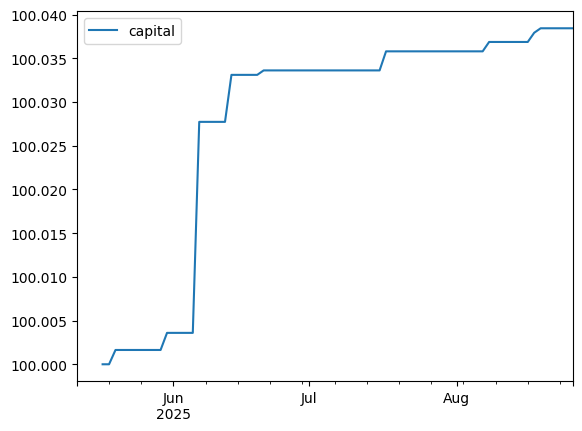

In [105]:
capital.rolling(5).sum().plot.line()
print(capital[-5:].sum())

### Debug optimal strategy with k=4 max trades per day

In [138]:
sim_params = SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)

res, capital_4trades = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=1, take_profit=1.02, lower_entry=0.995)
 Count bids 6843 in total, avg.bids per day 93.73972602739725,  filled bids 28, fill bids percent = 0.004091772614350431
  Stop loss events: count = 28, net loss = 0.031023671732673286 
  Take profit events: count = 5, net profit = 0.014129767822169681 
  Start capital = 100, Resulting capital: 100.0310236717325 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year


In [140]:
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==0)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_1h.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: nan


,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return


In [146]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==1)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_1h.mean()}')
res[filter_take_profit].head(10)

Average real close price if not take_profit: 1.0048873049418494


,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return,realised_profit
158,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.000570,0.987853,0.987853,-0.57,0.011628,0.232558,1,1,0,0.233721,-0.000465,0.233256,1.003
167,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.001503,0.990619,0.990619,-0.57,0.011628,0.232558,1,1,0,0.233721,-0.000465,0.233256,1.003
169,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.001503,0.990619,0.990619,-0.57,0.011628,0.232558,1,1,0,0.233721,-0.000465,0.233256,1.003
867,143.434006,JPY=X,2025-05-23,0,3.0,1.000195,1.000426,0.991993,0.993974,-0.57,0.014493,0.289855,1,1,0,0.291304,-0.000580,0.290725,1.003
890,142.623001,JPY=X,2025-05-23,0,4.0,0.999853,1.000426,0.991993,0.993974,-0.57,0.014493,0.289855,1,1,0,0.291304,-0.000580,0.290725,1.003
1334,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.013645,0.980826,0.992165,-0.57,0.013514,0.270294,1,1,0,0.271645,-0.000541,0.271105,1.003
1342,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.005701,0.973139,0.993680,-0.57,0.013514,0.270294,1,1,0,0.271645,-0.000541,0.271105,1.003
1343,77.875000,RUB=X,2025-05-30,0,3.0,1.009310,1.012098,0.979328,0.984290,-0.57,0.013514,0.270294,1,1,0,0.271645,-0.000541,0.271105,1.003
1347,77.375000,RUB=X,2025-05-30,0,4.0,0.994960,1.013645,0.980826,0.992165,-0.57,0.013514,0.270294,1,1,0,0.271645,-0.000541,0.271105,1.003
1355,77.375000,RUB=X,2025-05-30,0,4.0,0.994960,1.005701,0.973139,0.993680,-0.57,0.013514,0.270294,1,1,0,0.271645,-0.000541,0.271105,1.003


In [145]:
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_1h.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_1h','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: nan


,count,mean,std,min,25%,50%,75%,max
growth_future_1h,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
realised_profit,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


capital    600.174132
dtype: float64


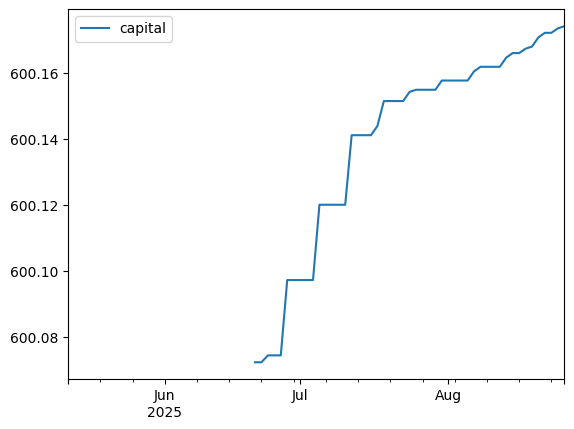

In [147]:
capital_4trades.rolling(30).sum().plot.line()
print(capital_4trades[-30:].sum())

### Debug optimal strategy with k=1 max trades per day

In [148]:
sim_params = SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1, lower_entry=0.995)

res, capital_1_trade = simulate(trade_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=100, threshold=0.58, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1, lower_entry=0.995)
 Count bids 1685 in total, avg.bids per day 23.40277777777778,  filled bids 6, fill bids percent = 0.0035608308605341245
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 6, net profit = 0.022525582754840734 
  Start capital = 100, Resulting capital: 100.02252558275478 
  CAGR in 4 years: 1.565 or 56.52 % of avg. growth per year


In [150]:
# NO STOP LOSS events
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_1h.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: nan


,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return


In [151]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_1h.mean()}')
res[filter_take_profit].head(5)

Average real close price if not take_profit: 1.0053009320672122


,Close_x,Ticker,Date,pred14_xgb2_proba,pred13_rank,growth_future_1h,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
14,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.000570,0.987853,0.987853,-0.57,0.071429,1.428571,1,0,1,1.435714,-0.002857,1.432857
23,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.001503,0.990619,0.990619,-0.57,0.071429,1.428571,1,0,1,1.435714,-0.002857,1.432857
25,79.724998,RUB=X,2025-05-13,0,1.0,1.009470,1.001503,0.990619,0.990619,-0.57,0.071429,1.428571,1,0,1,1.435714,-0.002857,1.432857
529,0.936110,EURCHF=X,2025-06-13,0,1.0,1.000641,1.001632,0.992406,0.993515,-0.57,0.043478,0.869565,1,0,1,0.873913,-0.001739,0.872174
1368,79.875000,RUB=X,2025-08-01,0,1.0,1.001377,1.001251,0.983155,0.990710,-0.57,0.058824,1.176624,1,0,1,1.182507,-0.002353,1.180154


In [152]:
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_1h.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_1h','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: nan


,count,mean,std,min,25%,50%,75%,max
growth_future_1h,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
realised_profit,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


capital    600.113974
dtype: float64


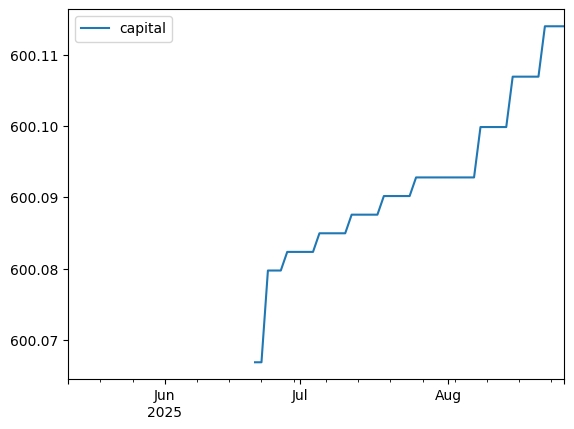

In [153]:
capital_1_trade.rolling(30).sum().plot.line()
print(capital_1_trade[-30:].sum())

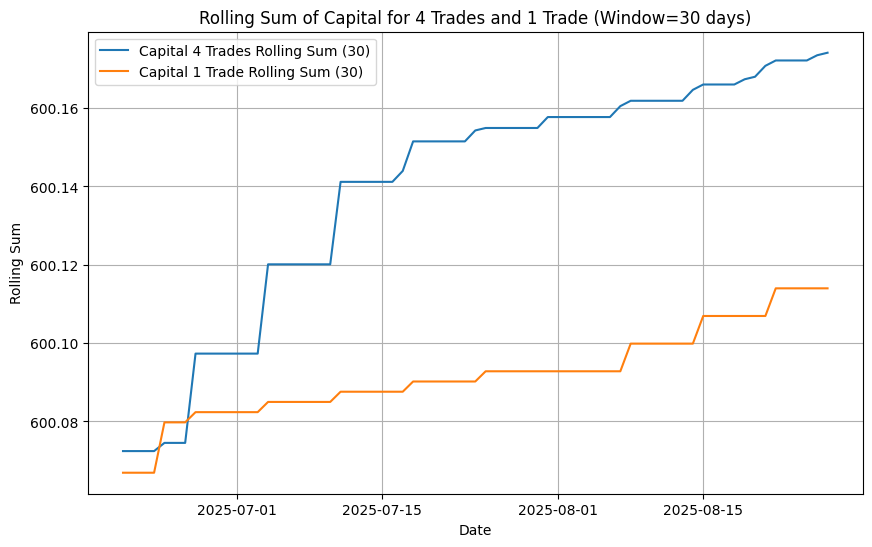

Capital 4 Trades Ending Sum: capital    600.174132
dtype: float64
Capital 1 Trade Ending Sum: capital    600.113974
dtype: float64


In [154]:
# Assuming capital_4trades and capital_1_trade are defined and have the same index
capital_4trades_rolling = capital_4trades.rolling(30).sum()
capital_1_trade_rolling = capital_1_trade.rolling(30).sum()

# Plot the rolling sums on the same graph
plt.figure(figsize=(10, 6))
plt.plot(capital_4trades_rolling, label='Capital 4 Trades Rolling Sum (30)')
plt.plot(capital_1_trade_rolling, label='Capital 1 Trade Rolling Sum (30)')
plt.legend(loc='best')
plt.title('Rolling Sum of Capital for 4 Trades and 1 Trade (Window=30 days)')
plt.xlabel('Date')
plt.ylabel('Rolling Sum')
plt.grid(True)
plt.show()

# Print the ending values
print(f"Capital 4 Trades Ending Sum: {capital_4trades[-30:].sum()}")
print(f"Capital 1 Trade Ending Sum: {capital_1_trade[-30:].sum()}")